In diesem Notebook zeige ich euch eine kurze Implementation der 1D Schrödingergleichung in einem elektrischen Feld mit der Berechnung von hohen Harmonischen.
Der zu simulierende Hamiltonian hat die Form $$\hat{H} = \frac{1}{2}\hat{p}^2 + \hat{V}(\hat{x}) + E_0 \hat{x} f(t) \cos(\omega t).$$ Dabei ist f(t) der Puls-Einhüllende und meist in einer $\sin^2$-Form gewählt.
Wir starten damit alle Module zu importieren, die wir benötigen werden. Da wir hier die Matrixexponentiale bestimmen wollen, werden wir die "sparse"-Module von Scipy benötigen und natürlich mit Tabellen und vektorisierten Funktionen in Numpy umgehen. Für die Darstellung verwenden wir Standard-Matplotlib-Funktionen. Der Start der Propagation wird auf $t=0$ gesetzt.

Die Randbedingungen sind $\psi(x_{\text{min}})=0$ und $\psi(x_{\text{max}})=0$ (Dirichlet). Dabei werden die äußeren Punkte ausserhalb der Region fortgesetzt. Die Exponentiation wird hier von einer spärlichen Matrix direkt vorgenommen. Es ist aber auch möglich, direkt einen Operator zu definieren und diesen zu verwenden.

In [1]:
#%matplotlib notebook
%matplotlib widget
import numpy as np
import scipy.sparse as ssp
import scipy.sparse.linalg as ssla
import matplotlib.pyplot as plt

from classes_and_functions import vpotential, venvelope, Hamiltonian

Als nächstes wird festgelegt, wie groß unser System ist, indem wir $x_{\text{min}}$ und $x_{\text{max}}$ festlegen. Dann wird mit neigs die Anzahl der zu berechnenden Zustände fixiert.
Das Simulationsgebiet kann unterschiedlich zerteilt werden, zum einen können wir ein uniformes Grid mit linspace verwenden oder ein nicht uniformes mit z.B. einer Funktion angeben.
Zur Bestätigung der Startbedingung wird die Einhüllende Zeitfunktion, die Potentialfunktion und die ersten 4 Eigenzustände dargestellt. Ausserdem werden die Eigenenergien angegeben.
Dabei ist zu beachten, dass das innere Produkt die Jacobi-Determinante des Grids mitträgt. Der Hamiltonian ist in der Matrixdarstellung nicht hermitesch und erzeugt daher keine orthonormalen Eigenvektoren (unter dem Standard-Inneren-Produkt). Daher müssen diese neu normiert werden (siehe overlap). Overlap ist dabei eine Diagonalmatrix, da das neue innere Produkt dafür sorgt.

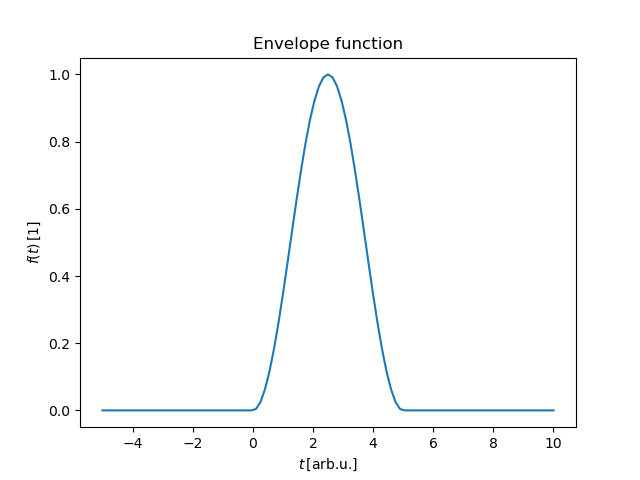

First few eigenvalues of the system: [-0.99034233 -0.25229997 -0.12995086 -0.07133203 -0.04854739 -0.03297041
 -0.02516289 -0.01890898]


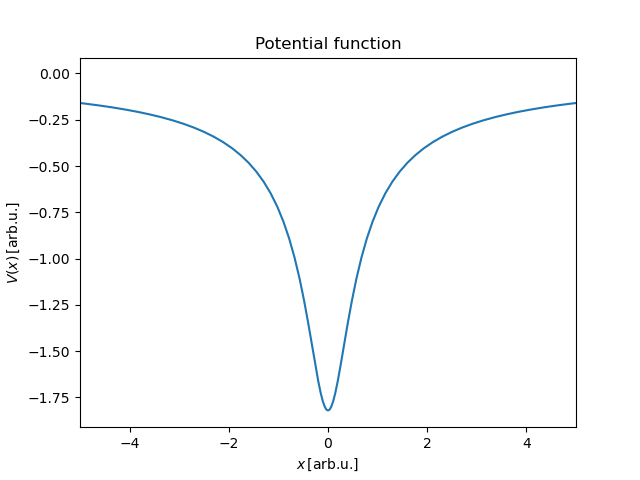

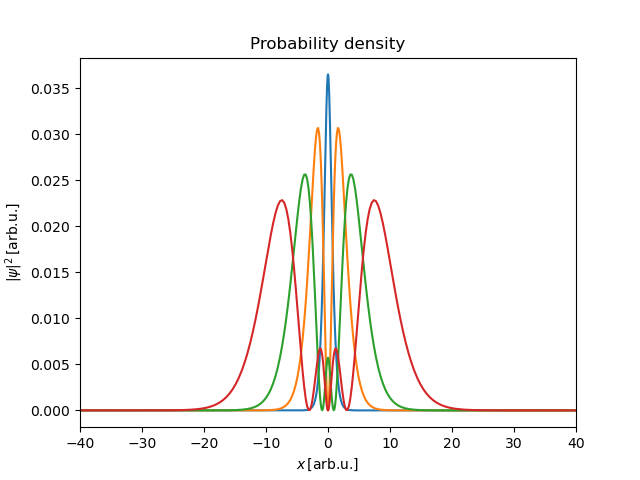

In [2]:
neigs =    8 # number of eigenstates
xmin  = -160 # left end of the x intervall
xmax  =  160 # right end of the x intervall
nx    =  401 # number of x points

# different grid definitons for xmin to xmax
# random grid:
#xs = np.cumsum(np.random.rand(nx))
#xs = (xs - xs[0]) / (xs[-1] - xs[0]) * (xmax - xmin) + xmin
# linear grid:
#xs = np.linspace(xmin, xmax, nx)
# square grid:
ymax = np.sqrt(xmax)
ymin = -np.sqrt(abs(xmin))
ys = np.linspace(ymin, ymax, nx)
xs = np.sign(ys) * ys**2

# plot of the pulse envelope
ts = np.linspace(-5, 10, 101)
plt.figure()
plt.plot(ts, venvelope(ts, 5))
plt.title("Envelope function")
plt.xlabel("$t \,$[arb.u.]")
plt.ylabel("$f(t)\,[1]$")
plt.show()


# Building the Hamiltonian
ham = Hamiltonian(xs, order = 4)
# Solving the eigensystem
evals, evecs = ssla.eigs(ham.H_0, neigs, which = "SR", maxiter = 1e6)
evals = evals.real
print("First few eigenvalues of the system:", evals.real)

# plot of the potential over position
plt.figure()
plt.plot(xs, vpotential(xs))
plt.title("Potential function")
plt.xlim(-5,5)
plt.xlabel("$x \,$[arb.u.]")
plt.ylabel("$V(x) \,$[arb.u.]")
plt.show()

# plot of the probability density over position
plt.figure()
for i in range(4):
    plt.plot(xs, np.abs(evecs[:, i])**2)
plt.title("Probability density")
plt.xlim(-40,40)
plt.xlabel("$x \,$[arb.u.]")
plt.ylabel("$|\psi|^2 \,$[arb.u.]")
plt.show()

# calculation of the overlap of the eigenstates in the new inner product
overlap = np.empty((neigs, neigs), dtype = np.float64)
for i in range(neigs):
    for j in range(neigs):
        overlap[i, j] = evecs[:, i].conj().dot(ham.jac * evecs[:, j]).real
    evecs[:, i] = evecs[:, i] / np.sqrt(overlap[i, i])

Nun müssen wir noch die Parameter des Pulses festlegen und dem Hamiltonian übergeben. Wir wollen 10 optische Zyklen, eine Kopplungsstärke von 0.2 und eine Kreisfrequenz von 0.4. Das Ende des Pulses ist dann durch diese Parameter eindeutig festgelegt.

In [3]:
Nopt = 10 # number of optical cycles
omega = 0.4 # central angular frequency of the pulse
Tend = Nopt * 2 * np.pi / omega # end time of the pulse
E_0 = 0.2 # electric field strength

ham.set_pulse_length(Tend) # set the pulse length
ham.minimal_coupling_phi(E_0, omega) # coupling the field to the Hamiltonian

Jetzt kommt der Zeitpropagationsteil. In den Funktionen CFM4 (Commutator free magnus 4th order), CN (Crank Nicholson) und exp_midpt (exponential midpoint) sind hier 3 Methoden angegeben. Der Startvektor ist der Grundzustand und das Zeitintervall [0, Tend] wird in nt Teile zerlegt. Hier wird keine Schrittweitenanpassung verwendet. In fidelity wird der Überlapp mit dem Grundzustand und in psi_t wird der Zustand zu jedem Speicherzeitschritt gelagert. Es ist nicht immer notwendig, dass jeder genommene vom Propagator genommene Zeitschritt genommen wird. Daher gibt es die Option die Anzahl der Speicherzeiten zu verringern. Hierbei sollte (nt - 1) / (nt_save - 1) eine ganze Zahl sein. Es kann mit den unterschiedlichen Propagatoren herumprobiert werden. Vorsicht ist bei den Matrixexponentialmethoden geboten, wenn die Norm der Matrix groß wird (z.B. bei nicht uniformen Grids).

In [4]:
psi0 = evecs[:, 0] # ground state
sqr36 = np.sqrt(3.0) / 6.0 # parameter for CFM4

def CFM4(t, dt, psi):
    """
    Implementation of the commutator free Magnus method of 4th order
    Input:
        time (float, double): t
        time step (float, double): dt
        state at time t (numpy array): psi
    Output:
        state at time t + dt (numpy array)
    """
    c1t = t + (0.5 - sqr36) * dt
    c2t = t + (0.5 + sqr36) * dt
    alpha1 = 0.25 - sqr36
    alpha2 = 0.25 + sqr36
    H1 = ham.build_at_time(c1t)
    H2 = ham.build_at_time(c2t)
    exp1 = -1j * (alpha1 * H1 + alpha2 * H2) * dt
    exp2 = -1j * (alpha2 * H1 + alpha1 * H2) * dt
    return ssla.expm_multiply(exp1, ssla.expm_multiply(exp2, psi))

def exp_midpt(t, dt, psi):
    """
    Implementation of the exponential midpoint rule
    Input:
        time (float, double): t
        time step (float, double): dt
        state at time t (numpy array): psi
    Output:
        state at time t + dt (numpy array)
    """
    c1t = t + 0.5 * dt
    H1 = ham.build_at_time(c1t)
    exp = -1j * H1 * dt
    return ssla.expm_multiply(exp, psi)

unit = ssp.eye(nx) # unit matrix for the Crank Nicholson method
def CN(t, dt, psi):
    """
    Implementation of the Crank Nicholson algorithm
    Input:
        time (float, double): t
        time step (float, double): dt
        state at time t (numpy array): psi
    Output:
        state at time t + dt (numpy array)
    """
    c1t = t + 0.5 * dt
    H1 = ham.build_at_time(c1t)
    rhs = psi - 0.5j * dt * H1.dot(psi)
    lhs = unit + 0.5j * dt * H1
    return ssla.spsolve(lhs, rhs)

nt = 6401 # number of time steps
nt_save = 3201 # number of time steps where the observables get evaluated
ndt_save = int((nt - 1) / (nt_save - 1))
ts = np.linspace(0, Tend, nt)
ts_plot = np.linspace(0, ts[-1], nt_save)
dt = ts[1] - ts[0] # time step of the equidistant time space
psi = psi0.copy()

psi_t = np.empty((nt_save, nx), dtype = np.complex128)
fidelity = np.empty((nt_save,), dtype = np.float64)

fidelity[0] = np.abs(psi.conj().dot(ham.jac * psi0))
psi_t[0]    = psi.copy()
i_t_ctr = 0
for i_t, t in enumerate(ts[:-1]):
    psi = CN(t, dt, psi)
    #psi = CFM4(t, dt, psi)
    #psi = exp_midpt(t, dt, psi)
    if i_t % ndt_save == 0:
        i_t_ctr += 1
        fidelity[i_t_ctr] = np.abs(psi.conj().dot(ham.jac * psi0))
        psi_t[i_t_ctr] = psi.copy()


Jetzt können die Ergebnisse dargestellt werden. Dafür wird die Fidelity über der Zeit dargestellt und der Zustand als Animation im Ort. Es wird nur ein Ausschnitt des Simulationsgebiets angeschaut, da der Effekt dann besser zu erkennen ist.

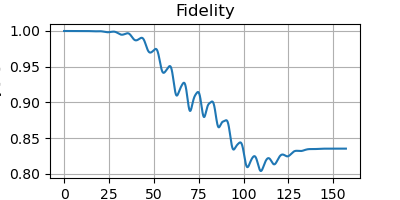

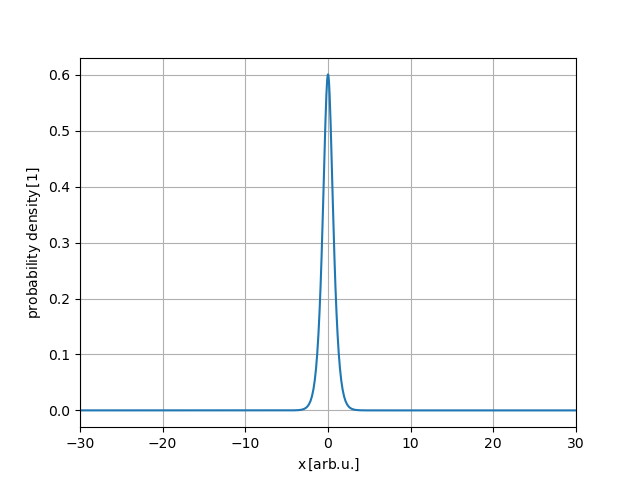

In [5]:
plt.figure(figsize = (4,2))
plt.plot(ts_plot, fidelity)
plt.title("Fidelity")
plt.xlabel("time$\,$[arb.u.]")
plt.ylabel("fidelity$\,$[1]")
plt.grid()
plt.show()

import matplotlib.animation as animation
fig, ax = plt.subplots()

line, = ax.plot(xs, np.abs(psi_t[0])**2)
plt.xlim(-30, 30)
plt.xlabel("x$\,$[arb.u.]")
plt.ylabel("probability density$\,$[1]")
plt.grid()

def init():
    line.set_ydata([np.nan] * len(xs))
    return line,

def animate(i):
    line.set_ydata(np.abs(psi_t[i])**2)  # update the data.
    return line,

ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True)#, save_count=50)

plt.show()

Es ist auch immer gut die Besetzungen der Eigenzustände in der Zeit zu betrachten, da es Auskunft über die nichtlinearen Prozesse liefert.

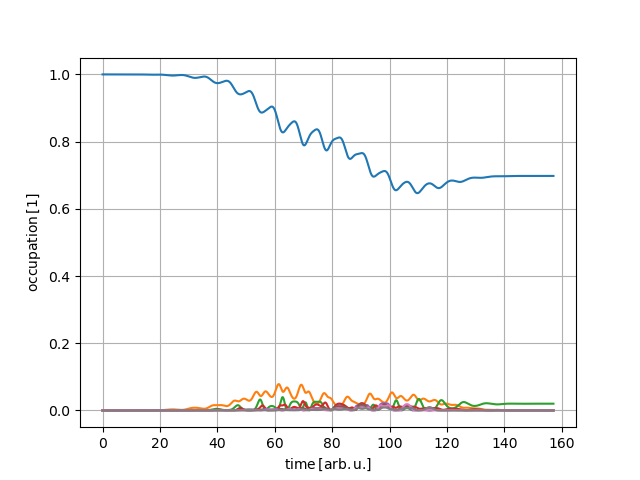

In [6]:
n_i = np.empty((nt_save, neigs))
for i in range(neigs):
    n_i[:, i] = np.abs(psi_t.dot(ham.jac * evecs[:,i]))**2

plt.figure()
plt.plot(ts_plot, n_i)
plt.xlabel("time$\,$[arb.$\,$u.]")
plt.ylabel("occupation$\,$[1]")
plt.grid()
plt.show()

Für die Berechnung der hohen Harmonischen benötigen wir noch das Dipolmoment und dessen zweite Ableitung in der Zeit. Davon muss dann noch die Fourier Transformierte gebildet und dargestellt werden.

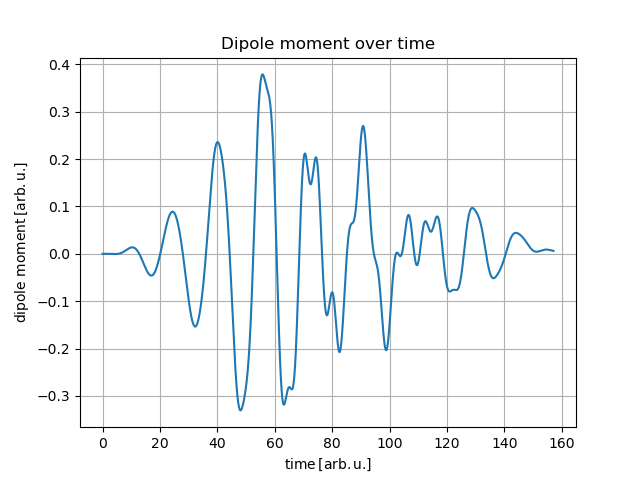

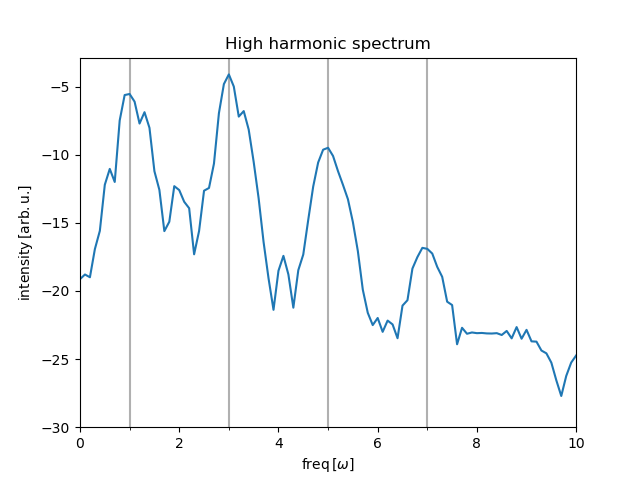

In [7]:
# calculation of the dipole moment
dip_x = np.empty((nt_save,), dtype = np.float64)
for i_t in range(nt_save):
    dip_x[i_t] = psi_t[i_t].conj().dot(ham.jac * xs * psi_t[i_t]).real

# plot of the dipole moment over time
plt.figure()
plt.title("Dipole moment over time")
plt.plot(ts_plot, dip_x)
plt.xlabel("time$\,$[arb.$\,$u.]")
plt.ylabel("dipole moment$\,$[arb.$\,$u.]")
plt.grid()
plt.show()

# acceleration of the dipole moment and Fourier transform
acc_dip_x = np.diff(dip_x, 2)
fft_acc_dip_x = np.abs(np.fft.fft(acc_dip_x))**2
freq = np.fft.fftfreq(nt_save - 2, d=dt * ndt_save)
sort_freq = np.argsort(freq)
omegas = 2 * np.pi * freq[sort_freq]
fft_acc_dip_x = fft_acc_dip_x[sort_freq]

# plot of the high harmonic spectrum
fig, ax = plt.subplots()
plt.title("High harmonic spectrum")
plt.plot(np.real(omegas / omega), np.log(fft_acc_dip_x))
ax.set_xlabel("freq$\,$[$\omega$]")
ax.set_ylabel("intensity$\,$[arb.$\,$u.]")
plt.xlim(0, 10)
#plt.ylim(-11, -3)
minor_ticks = np.arange(1, 9, 2)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(which = 'minor', linewidth = 1.5, axis = 'x')
plt.show()

Wir können auch den klassischen Cutoff berechnen, ab dem die HHG-Intensität abnehmen sollte. Sie ist gegeben durch $I_{\text{p}} + 3.17 U_{\text{p}}$. Dabei ist $I_{\text{p}}$ die Ionisationsenergie (hier die Differenz des Grundzustands zur 0-Energie) und $U_{\text{p}}$ die ponderomotive Energie des elektrischen Feldes.

In [8]:
Up = E_0**2 / (4 * omega**2)
Ip = -evals[0]
(3.17 * Up + Ip) / omega

2.9711683148944013

Wenn wir also nun solch ein Setup hätten, könnte man nach einer Beleuchtung einer Atomwolke mit einem linear polarisierten Laser mit einem Photodetektor die hohen Harmonischen der Laserfrequenz messen.